# Solving Linear Complementarity Problems with QuantEcon.py

**Daisuke Oyama**

*Faculty of Economics, University of Tokyo*

This notebook demonstrates the usage of the linear complementarity problem (LCP) solver
[`lcp_lemke`](https://quanteconpy.readthedocs.io/en/latest/optimize/lcp_lemke.html#quantecon.optimize.lcp_lemke.lcp_lemke)
in `QuantEcon.py`.
As an example, we solve optimal stopping problems by reformulating those as LCPs
(Cottle, Pang, and Stone, 1992, *The Linear Complementarity Problem*, Section 1.2).

In [1]:
%matplotlib inline

In [2]:
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, prange
import quantecon as qe

## Linear Complementarity Problems

Given a matrix $M \in \mathbb{R}^{n \times n}$ and a vector $q \in \mathbb{R}^n$,
an LCP is to find a vector $z \in \mathbb{R}^n$ such that
$$
\begin{aligned}
&z \geq 0, \\
&M z + q \geq 0, \\
&z \cdot (M z + q) = 0.
\end{aligned}
$$
Such a problem arises as the KKT conditions for quadratic programs, computation of Nash equilibria of two-player games, and Markov optimal stopping problems as we consider below, among others.

As a simple such problem, let us consider:

In [3]:
M = np.array([[1, 0, 0],
              [2, 1, 0],
              [2, 2, 1]])
q = np.array([-8, -12, -14])

`QuantEcon.py` provides an LCP solver `qe.optimize.lcp_lemke`
(which implements "Lemke's method",
a pivoting algorithm similar to the simplex method for linear programming):

In [4]:
res = qe.optimize.lcp_lemke(M, q)

The return `res` is a namedtuple,
where `res.success` indicates whether the solver succeeded in finding a solution,
and, if `res.success==True`, `res.z` contains the found solution:

In [5]:
res.success

True

In [6]:
res.z

array([8., 0., 0.])

To verify that the returned vector is indeed a solution:

In [7]:
M @ res.z + q

array([0., 4., 2.])

In [8]:
res.z @ (M @ res.z + q)

0.0

## Optimal Stopping

Now we consider optimal stopping problems.
Examples include job search problems as we study below.

In each period, a state $s \in S = \{0, \ldots, n-1\}$ realizes
according to a Markov chanin with transition probability matrix $P \in \mathbb{R}^{n \times n}$.

The decision maker (DM) has two options: stop or continue.
If stop, then DM receives reward $r(s)$ and the process stops;
if continue, then DM receives reward $b(s)$ and the process proceeds to the next period.
DM makes decisions in order to maximize the expected discounted sum of rewards
with discount factor $\beta \in (0, 1)$.

The optimal value function of this dynamic program is denoted by $v \in \mathbb{R}^n$.
The Bellman equation is then:
$$
v(s) = \max\{r(s), b(s) + \beta (P v)(s)\}
\qquad (s \in S).
$$
This means: for each $s \in S$,
* $v(s) \geq r(s)$;
* $v(s) \geq b(s) + \beta (P v)(s)$; and
* at least one of these inequalities holds with equality.

Now denote $z = v - r \in \mathbb{R}^n$.
Then the above condition is equivalently written as:

* $z \geq 0$;
* $(I - \beta P) z + (I - \beta P) r - b \geq 0$; and
* $z \cdot [(I - \beta P) z + (I - \beta P) r - b] = 0$;

where $I$ is the $n \times n$ identity matrix.

This is precisely an LCP with
$$
\begin{aligned}
M &= I - \beta P, \\
q &= M r - b.
\end{aligned}
$$

In the following sections,
we specify reward functions $r$ and $b$ and Markov matrix $P$
in the context of job search problems as studied in
[Quantitative Economics with Python](https://python.quantecon.org/).

## Job Search with IID Wage Offers

Let us first consider the simple version in
[Job Search I: The McCall Search Model](https://python.quantecon.org/mccall_model.html).

In each period, DM receives a wage offer $w(s)$.
DM can either

* stop,
  by accepting the offer and work permanently at that wage,
  thus receiving a present value of $\frac{u(w(s))}{1 – \beta}$; or
* continue,
  by receiving a state-independent unemployment compensation $c$ and wait for the offer in the next period,

where $u$ is the instantaneous utility function,
and $\beta$ is the discount factor.

Thus, in the formulation above:

* $r(s) = \frac{u(w(s))}{1 - \beta}$;
* $b(s) \equiv u(c)$.

In this section, the utility function is assumed to be linear:
$u(w) = w$.

In this simple version,
the state $s$ is iid, drawn from
a [beta-binomial distribution](https://en.wikipedia.org/wiki/Beta-binomial_distribution) $p$.
Thus:

In [9]:
n = 51  # Number of states
a, b = 200, 100  # Parameters of beta-binomial distribution

p = qe.distributions.BetaBinomial(n-1, a, b).pdf()

P = np.empty((n, n))  # Markov matrix
P[:] = p

Wage offer function and unemployment compensation:

In [10]:
w_min, w_max = 10, 60
w = np.linspace(w_min, w_max, n)  # Wage offers

c = 25.  # Unemployment compensation

Discount factor:

In [11]:
beta = 0.99  # Discount factor

Now set up the LCP:

In [12]:
M = np.eye(n) - beta * P
q = M @ w / (1 - beta) - c

Then solve the problem with `lcp_lemke`:

In [13]:
res = qe.optimize.lcp_lemke(M, q)

`res.z` contains the solution to the LCP,
and the optimal value function is given by $v = z + r$ where $r = \frac{w}{1 - \beta}$:

In [14]:
v = res.z + w / (1 - beta)

Plot the optimal value function:

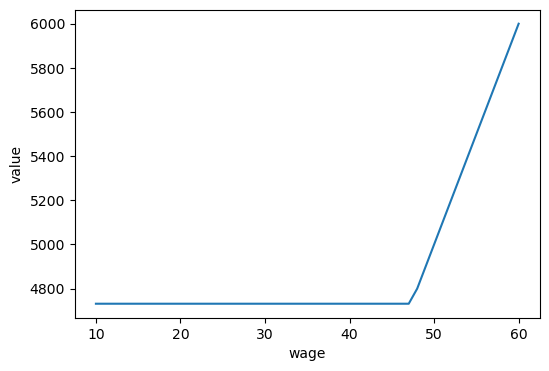

In [15]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(w, v, '-')
ax.set_xlabel('wage')
ax.set_ylabel('value')
plt.show()

The reservation utility $\bar{u}$, hence reservation wage
(which is state independent in this version) is given by
$$
\bar{u} = (1 - \beta) \left(u(c) + \beta p \cdot v\right),
$$
where DM stops if and only if $u(w) \geq \bar{u}$.

In [16]:
(1 - beta) * (c + beta * p @ v)

47.316499766606455

### Comparative Statics

Let us compute the reservation wage for various values of $c$ and $\beta$.

We can use `Numba` to produce fast code,
as `lcp_lemke` is Numba-jit compiled.

In [17]:
@jit(nopython=True)
def compute_reservation_utility(P, u_w, u_c, beta):
    n = len(P)
    M = np.eye(n) - beta * P
    q = M @ u_w / (1 - beta) - u_c
    res = qe.optimize.lcp_lemke(M, q)
    v = res.z + u_w / (1 - beta)
    out = (1 - beta) * (u_c + beta * P @ v)
    return out

In [18]:
# Warmup
compute_reservation_utility(P, w, c, beta)[0]

47.316499766606455

Compute the reservation wage for different values of $c$'s and $\beta$'s:

In [19]:
@jit(nopython=True, parallel=True)
def comparative_statics_iid(P, u_w, u_c_vals, beta_vals):
    n_u_c_vals = u_c_vals.size
    n_beta_vals = beta_vals.size
    R = np.empty((n_u_c_vals, n_beta_vals))
    
    for i in prange(n_u_c_vals):
        for j in range(n_beta_vals):
            out = compute_reservation_utility(P, w, u_c_vals[i], beta_vals[j])
            R[i, j] = out[0]
            
    return R

In [20]:
# Warmup
comparative_statics_iid(P, w, np.array([c]), np.array([beta]))

array([[47.31649977]])

In [21]:
grid_size = 25
c_vals = np.linspace(10.0, 30.0, grid_size)
beta_vals = np.linspace(0.9, 0.99, grid_size)

%time R = comparative_statics_iid(P, w, c_vals, beta_vals)

CPU times: user 168 ms, sys: 3.61 ms, total: 172 ms
Wall time: 14.6 ms


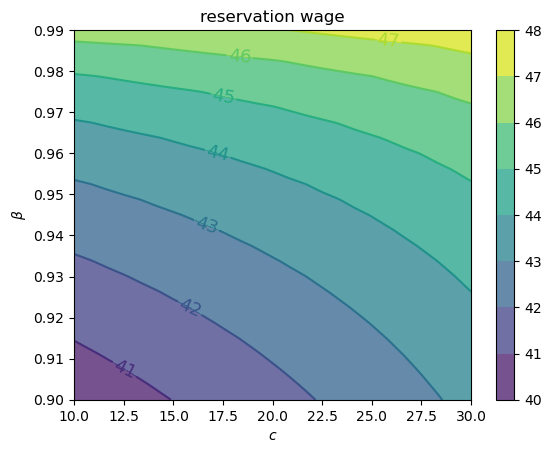

In [22]:
fig, ax = plt.subplots()

cs1 = ax.contourf(c_vals, beta_vals, R.T, alpha=0.75)
ctr1 = ax.contour(c_vals, beta_vals, R.T)

plt.clabel(ctr1, inline=1, fontsize=13)
plt.colorbar(cs1, ax=ax)

ax.set_title("reservation wage")
ax.set_xlabel("$c$")
ax.set_ylabel(r"$\beta$")

ax.ticklabel_format(useOffset=False)

plt.show()

## Job Search with Correlated Wage Offers

We now introduce correlation in the wage offer process.
Specifically, we consider a simplified version of the one studied in
[Job Search IV: Correlated Wage Offers](https://python.quantecon.org/mccall_correlated.html).

The wage offer is given by
$$
w_t = \exp(x_t) + 1,
$$
where $\{x_t\}$ evolves according to
$$
x_{t+1} = d + \rho x_t + \sigma \epsilon_{t+1}
$$
with IID standard normal $\{\epsilon_t\}$.

In the lecture, the wage is given by
$w_t = \exp(x_t) + \exp(\mu + s \zeta_t)$ with IID standard normal $\{\zeta_t\}$,
where $\mu = 0$ and $s = 1$ in the code there.
Here, we are letting $\mu = s = 0$.

In [23]:
d = 0.
rho = 0.9
sigma = np.sqrt(0.1)  # sigma = 0.1 in the lecture
c = 5.
beta = 0.98

We approximate the $\{x_i\}$ process with a Markov chain by the Tauchen method,
implemented by [`qe.markov.tauchen`](https://quanteconpy.readthedocs.io/en/latest/markov/approximation.html#quantecon.markov.approximation.tauchen):

In [24]:
n = 100
mc = qe.markov.tauchen(n, rho, sigma, d)
w = np.exp(mc.state_values) + 1

For the instantaneous utility function, we assume $u(c) = \log c$.

In [25]:
u_bar = compute_reservation_utility(mc.P, np.log(w), np.log(c), beta)
w_bar = np.exp(u_bar)

The reservation wage now varies according to the current state $x$:

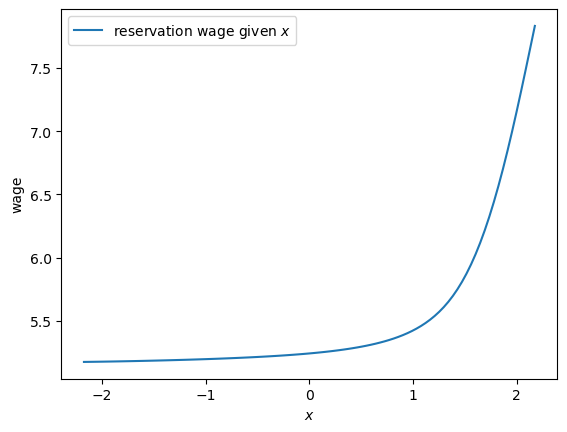

In [26]:
fig, ax = plt.subplots()
ax.plot(mc.state_values, w_bar, label="reservation wage given $x$")
ax.set(xlabel="$x$", ylabel="wage")
ax.legend()
plt.show()

The reservation wage for different values of unemployment compensation $c$:

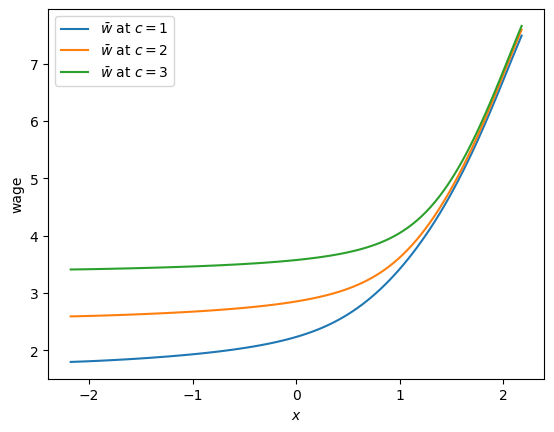

In [27]:
c_vals = 1, 2, 3

fig, ax = plt.subplots()

for c in c_vals:
    u_bar = compute_reservation_utility(mc.P, np.log(w), np.log(c), beta)
    ax.plot(mc.state_values, np.exp(u_bar), label=rf"$\bar w$ at $c = {c}$")

ax.set(xlabel="$x$", ylabel="wage")
ax.legend()
plt.show()

### Unemployment Duration

Next we simulate the unemployment duration for different values of
unemployment compensation $c$.

In [28]:
@jit(nopython=True, parallel=True)
def compute_unemployment_durations(P, state_values, u_c_vals, beta, X_indices):
    w = np.exp(state_values) + 1
    u_w = np.log(w)
    n_u_c_vals = u_c_vals.size
    num_reps, t_max = X_indices.shape
    
    mean_durations = np.empty(n_u_c_vals)
    
    for i in prange(n_u_c_vals):
        u_bar = compute_reservation_utility(P, u_w, u_c_vals[i], beta)
        
        duration_sum = 0
        for j in range(num_reps):
            t = 0
            while t < t_max:
                idx = X_indices[j, t]
                if u_w[idx] >= u_bar[idx]:
                    break
                t += 1
            duration_sum += t
            
        mean_durations[i] = duration_sum / num_reps
        
    return mean_durations

In [29]:
t_max = 3000
num_reps = 10000

# Generate seed by np.random.SeedSequence().entropy
seed = 46772388144553870973964263702460281200

# Generate sequences of state indices
# Initial condition x_0 approx 0
X_indices = mc.simulate_indices(t_max, init=mc.n//2, num_reps=num_reps,
                                random_state=np.random.default_rng(seed))

In [30]:
# Warmup
c = 5.
beta = 0.98
compute_unemployment_durations(
    mc.P, mc.state_values, np.log([c]), beta, X_indices
)

array([262.8538])

In [31]:
c_vals = np.linspace(1.0, 5.0, 20)  # Values of c
u_c_vals = np.log(c_vals)  # Values of u(c)

In [32]:
%%time
durations = compute_unemployment_durations(
    mc.P, mc.state_values, u_c_vals, beta, X_indices
)

CPU times: user 107 ms, sys: 2.01 ms, total: 109 ms
Wall time: 9.37 ms


Plot the results:

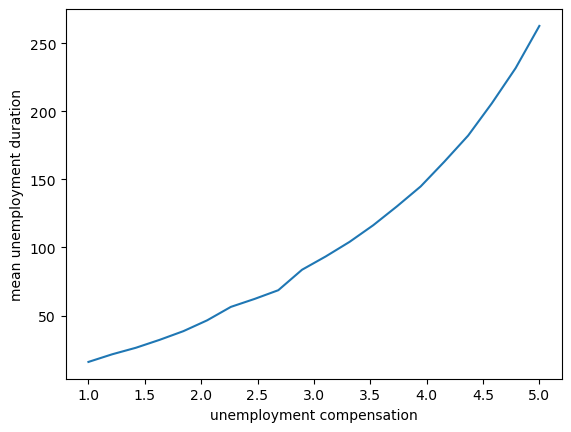

In [33]:
fig, ax = plt.subplots()
ax.plot(c_vals, durations)
ax.set_xlabel("unemployment compensation")
ax.set_ylabel("mean unemployment duration")
plt.show()